# Budget accounting with diffprivlib

Diffprivlib includes a budget accountant to allow you to keep track of privacy budget being spent. The budget accounting is handled by the `BudgetAccountant` class.

Basic functionality of the `BudgetAccountant` includes initialisation with an appropriate `epsilon` and `delta` (if desired), determining the total current spend with `total()` and evaluating the remaining budget to be spent with `remaining()`. The number of recorded budget spends can be found using `len()`.

In [1]:
import matplotlib.pyplot as plt
from numpy.random import random
from diffprivlib import BudgetAccountant
from diffprivlib.tools import mean, var

X = random(100)

In [2]:
acc = BudgetAccountant(epsilon=5, delta=0)
dp_mean = mean(X, bounds=(0, 1), accountant=acc)

print("Total spent: %r" % (acc.total(),))
print("Remaining budget (for 1 query): %r" % (acc.remaining(),))
print("Remaining budget (for 4 queries): %r" % (acc.remaining(4),))
print("Number of queries recorded: %d" % len(acc))

Total spent: (epsilon=1.0, delta=0.0)
Remaining budget (for 1 query): (epsilon=4.0, delta=0.0)
Remaining budget (for 4 queries): (epsilon=1.0, delta=0.0)
Number of queries recorded: 1


If a query were to exceed the privacy budget specified in the accountant, an error is raised and execution ceases.

In [3]:
acc = BudgetAccountant(1.5, 0)

dp_mean = mean(X, epsilon=1, bounds=(0, 1), accountant=acc)

try:
    dp_std = var(X, epsilon=1, bounds=(0, 1), accountant=acc)
except Exception as e:
    print("Error raised {}: {}".format(type(e), e))

Error raised <class 'diffprivlib.utils.BudgetError'>: Privacy spend of (1,0) not permissible; will exceed remaining privacy budget. Use BudgetAccountant.remaining() to check remaining budget.


## Using `BudgetAccountant` to track privacy budget

There are three ways to use the `BudgetAccountant` class to track budget spend across many operations:
1. **Parametrisation:** Passed as a parameter (`accountant=acc`)
2. **Default:** Set as a default (`set_default()`)
3. **Context manager:** Using "`with`" over a block of code

In [4]:
acc_p = BudgetAccountant()
mean(X, epsilon=1.618, bounds=(0, 1), accountant=acc_p)

print("Total spend: %r" % (acc_p.total(),))

Total spend: (epsilon=1.618, delta=0.0)


In [5]:
acc_d = BudgetAccountant()
acc_d.set_default()
mean(X, epsilon=2.718, bounds=(0, 1))

print("Total spend: %r" % (acc_d.total(),))

Total spend: (epsilon=2.718, delta=0.0)


In [6]:
with BudgetAccountant() as acc_w:
    mean(X, epsilon=1.5705, bounds=(0, 1))
    var(X, epsilon=1.5705, bounds=(0, 1))

print("Total spend: %r" % (acc_w.total(),))

Total spend: (epsilon=3.141, delta=0.0)


# Setting the `slack`

Composition of privacy budgets typically add up linearly, that is unless you allow a slack in your `delta`. This is governed by the `slack` parameter in the initialisation.

The benefit of a non-zero slack is especially evident when many queries are being asked.

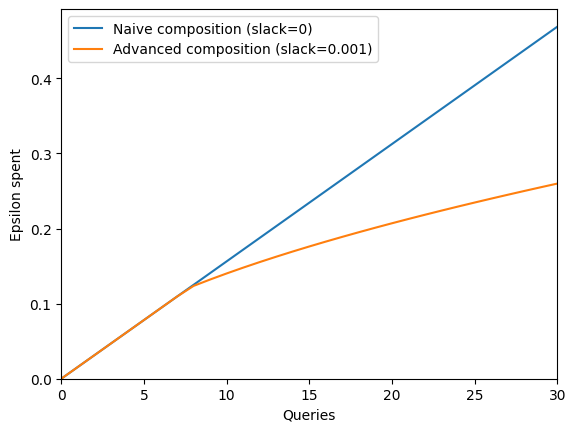

In [7]:
acc_n = BudgetAccountant()
acc_a = BudgetAccountant(slack=1e-3)
epsilon, queries = 2**-6, 30

budget_naive = [0] + [acc_n.spend(epsilon, 0).total()[0] for i in range(queries)]
budget_advanced = [0] + [acc_a.spend(epsilon, 0).total()[0] for i in range(queries)]

plt.plot(range(queries + 1), budget_naive, label="Naive composition (slack=%g)" % acc_n.slack)
plt.plot(range(queries + 1), budget_advanced, label="Advanced composition (slack=%g)" % acc_a.slack)
plt.xlabel("Queries")
plt.ylabel("Epsilon spent")
plt.xlim(0, queries)
plt.ylim(0, None)
plt.legend()



## Wat gebeurt er in jouw concept?

Wanneer je een model traint met `epsilon = 1.0`, gebruik je een **deel van je privacybudget**. Als je meerdere dingen doet (bijv. meerdere modellen, tools zoals `mean()` of `var()`), **tel je al die ε op**.

Dus ja:

### ➤ **Epsilon heeft een limiet**

Als je teveel gebruikt, is je "privacy op".
Dan krijg je een error, of je moet bewust méér privacy opofferen.

---

##  Wat doet *slack* hierbij?

**Slack verzacht de optelling van epsilon** over meerdere stappen.

In plaats van ε = 1 + 1 + 1 = 3 na drie acties, kan het met slack zijn:
ε ≈ 0.8 + 0.8 + 0.8 = 2.4

Dat betekent:

 Je gebruikt **minder budget per actie**
 Je kunt **meer stappen doen** met hetzelfde totale budget
 Je accepteert een **klein risico (delta)** dat iemand iets zou kunnen afleiden

---

##  Voor jouw project betekent dit:

* Als je **maar één model** traint (zoals je nu doet): **geen probleem** → `epsilon = 1.0` is prima
* Als je in de toekomst **meerdere modellen of stappen** tegelijk doet, wil je een **`BudgetAccountant` gebruiken met een `slack`**

  * Zo hou je controle over hoeveel privacy je al verbruikt hebt
  * En je kunt **slimmer omgaan met je totale ε**

